## CV08 - 개선된 U-Net 모델 만들기
### Step 1. KITTI 데이터셋 수집과 구축

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
            HorizontalFlip(p=0.5),   # 50%의 확률로 좌우대칭
            RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                min_max_height=(300, 370),
                w2h_ratio=370/1242,
                height=224,
                width=224,
                p=0.5
                ),
            Resize(              # 입력이미지를 224X224로 resize
                width=224,
                height=224
                )
            ])
    return Compose([     # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
        Resize(
            width=224,
            height=224
            )
        ])

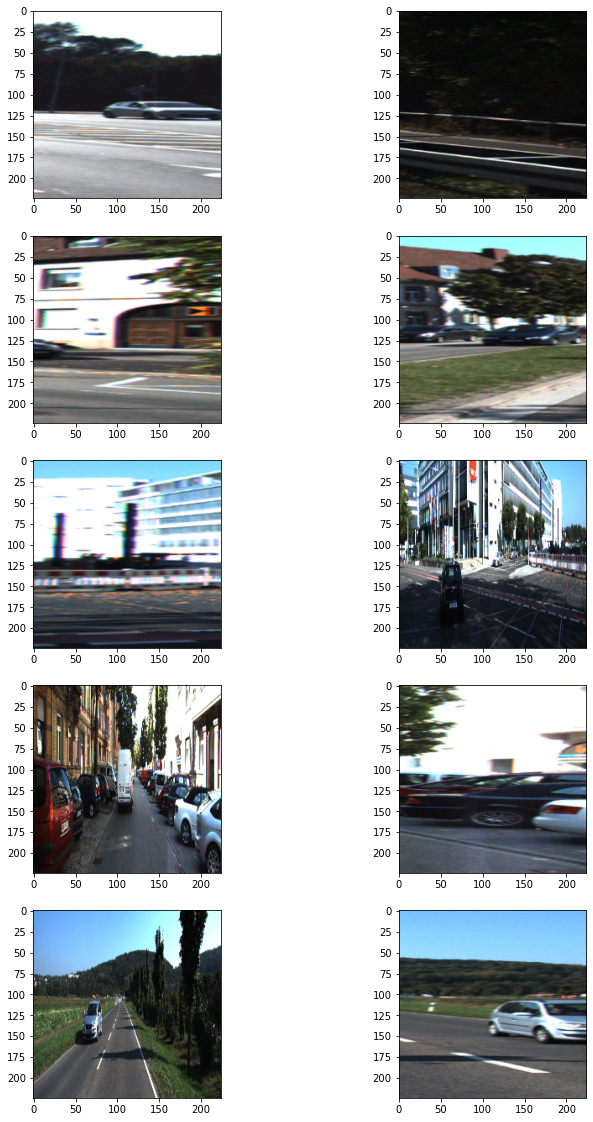

In [5]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))

for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])    # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

In [6]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    
  
    def __init__(self,
                 dir_path,
                 batch_size=16,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()
        
    

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[index*self.batch_size:(index + 1)*self.batch_size]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
                }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [7]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

### Step 2. U-Net++ 모델 구현

In [4]:
# 모델 구조 만들기
def conv(filters: int, kernel: int):
    return Conv2D(filters=filters, kernel_size=kernel, padding='same', activation='relu',
                  kernel_initializer='he_normal')

def build_model(input_shape=(224, 224, 3)):
    
    down_layer = []
    
    inputs = Input(input_shape)
    x = inputs
    
    for i in range(5):
        if i == 0:
            down_layer.append([conv(filters=64*(2**i), kernel=3)(x)])
        else:
            down_layer.append([conv(filters=64*(2**i), kernel=3)(down_layer[i-1][len(down_layer[i-1])-1])])
        down_layer[i].append(conv(filters=64*(2**i), kernel=3)(down_layer[i][0]))
        if i >= 3:
            down_layer[i].append(Dropout(0.5)(down_layer[i][1]))
        if i < 4:
            down_layer[i].append(
                MaxPooling2D(pool_size=(2,2))(down_layer[i][len(down_layer[i])-1]))
            

        for j in range(i):
            if i == 0:
                x = conv(filters=64*(2**(3-j)), kernel=2)(UpSampling2D(size=(2,2))(down_layer[4][2]))
            else:
                x = conv(filters=64*(2**(3-j)), kernel=2)(UpSampling2D(size=(2,2))(x))

            x = concatenate([down_layer[3-j][len(down_layer[3-j])-2], x], axis=3)

            x = conv(filters=64*(2**(3-j)), kernel=3)(x)
            x = conv(filters=64*(2**(3-j)), kernel=3)(x)
        
    output = Conv2D(2, 3, padding='same', activation='relu',
                     kernel_initializer='he_normal')(x)
    output = Conv2D(1, 1, activation='sigmoid')(output)
    
    model = Model(inputs=inputs, outputs=output)

    return model